# View GCaMP mismatch closed and open loop data

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from harp_resources import process, utils
from analysis_functions import *
from model_functions import *
import matplotlib.patches as patches
import seaborn as sns

In [2]:
RunTresholdDict = {'B3M1': 145, 'B3M2': 295, 'B3M3': 325, 'B2M4': 110, 'B2M5': 180}

In [3]:
G8_MM_1 = pd.read_csv('G8_MMclosed_open_session1.csv', dtype=dtype_dict)
G8_MM_2 = pd.read_csv('G8_MMclosed_open_session2.csv', dtype=dtype_dict)

In [4]:
# Chaning event name to halt and making it so that its True when there is a halt
#G8_MM_1.loc[:, 'event'] = G8_MM_1['event'].replace({False: True, True: False})
G8_MM_1.rename(columns = {'event': 'halt'}, inplace = True)
G8_MM_2.rename(columns = {'event': 'halt'}, inplace = True)


In [5]:
#Make sure the index provides inforamtion of seconds since start
G8_MM_1.set_index('Seconds', inplace=True)
G8_MM_2.set_index('Seconds', inplace=True)
# Theres only photomotry information from 15 seconds due to bleaching
G8_MM_1 = G8_MM_1.loc[ G8_MM_1.index>30]
G8_MM_2 = G8_MM_2.loc[ G8_MM_2.index>30]

In [6]:
#Check that the same mice are in the datsets
print(G8_MM_1.mouseID.unique())
print(G8_MM_2.mouseID.unique())


['B2M5' 'B2M4' 'B3M3' 'B3M1' 'B3M2']
['B2M5' 'B2M4' 'B3M3' 'B3M1' 'B3M2']


Plotted traces for B2M5


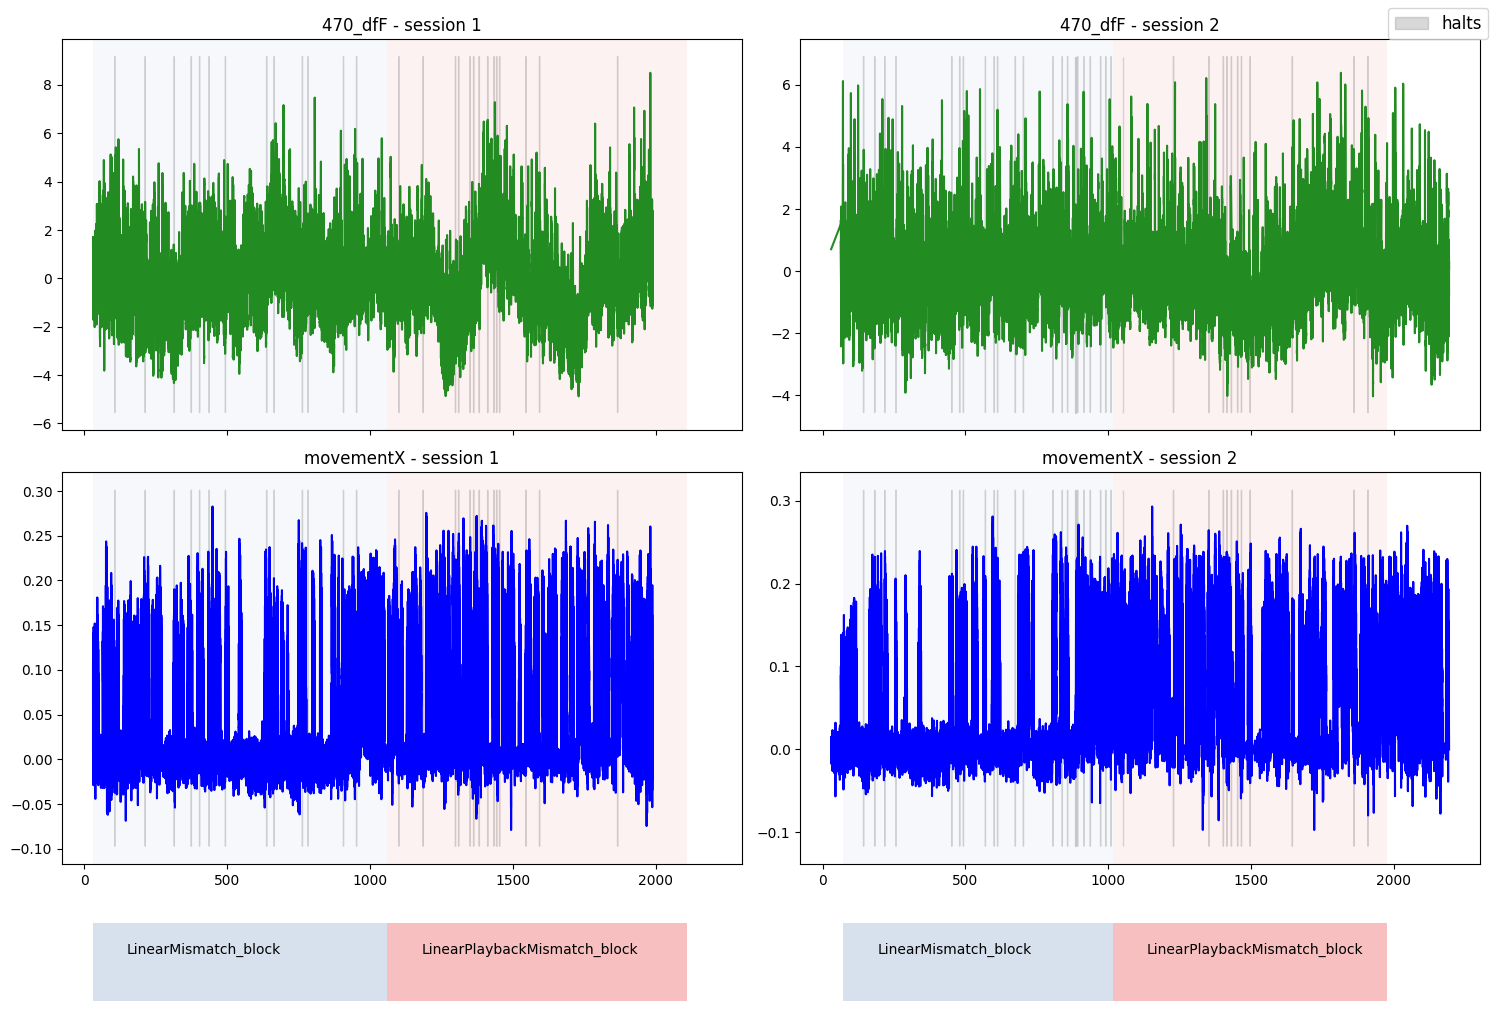

Plotted traces for B2M4


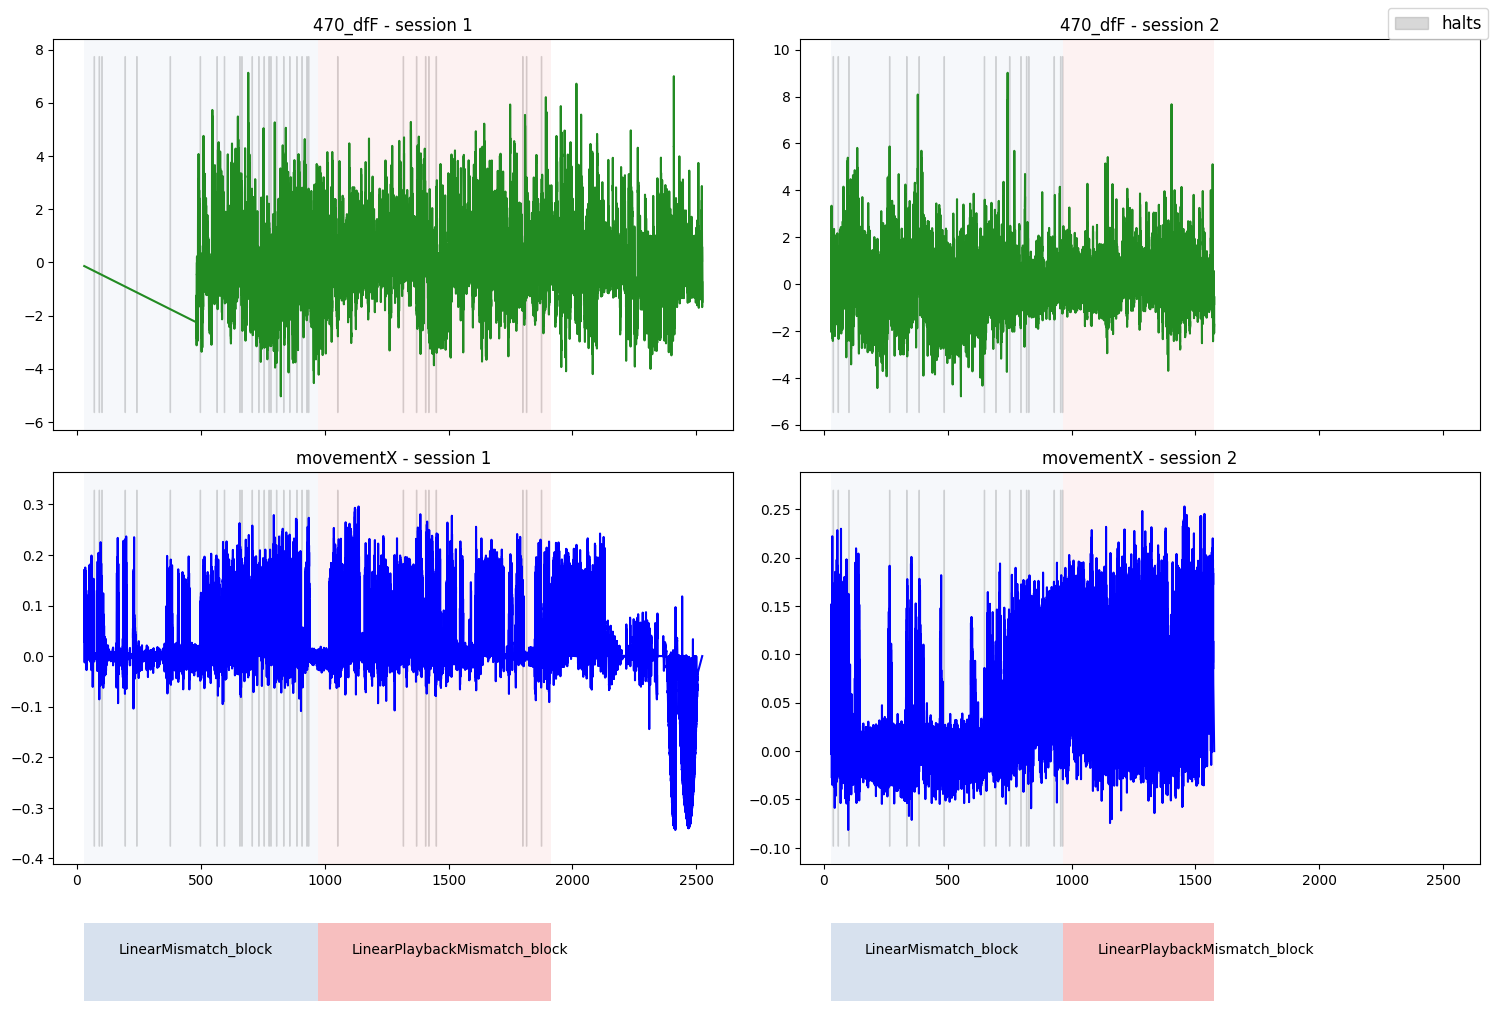

Plotted traces for B3M3


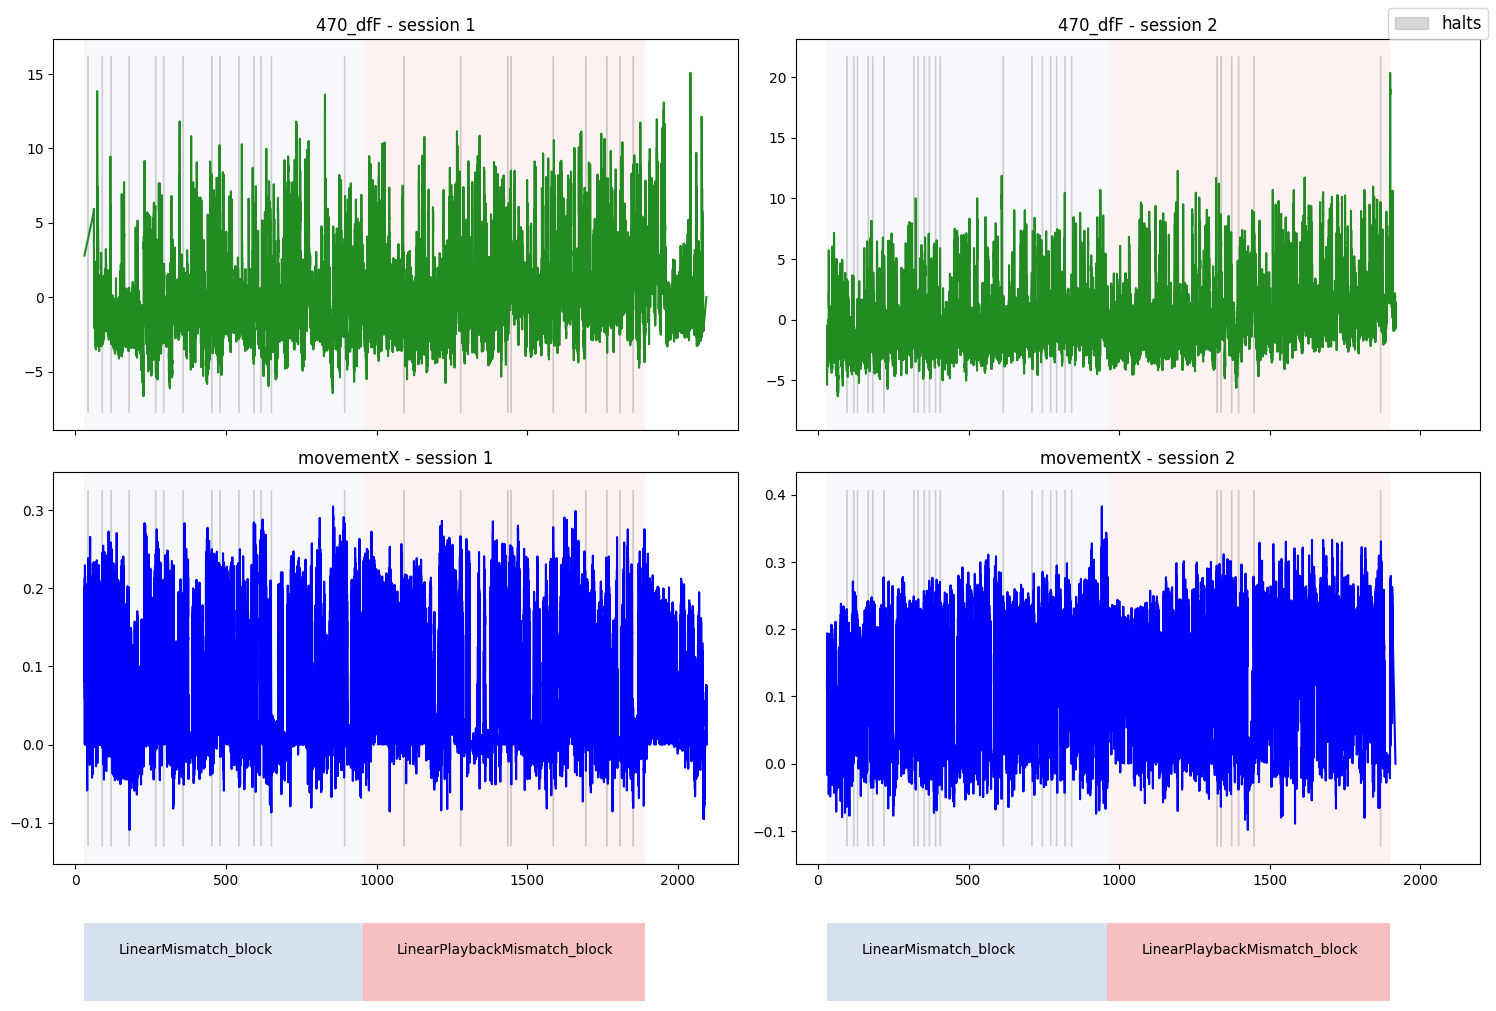

Plotted traces for B3M1


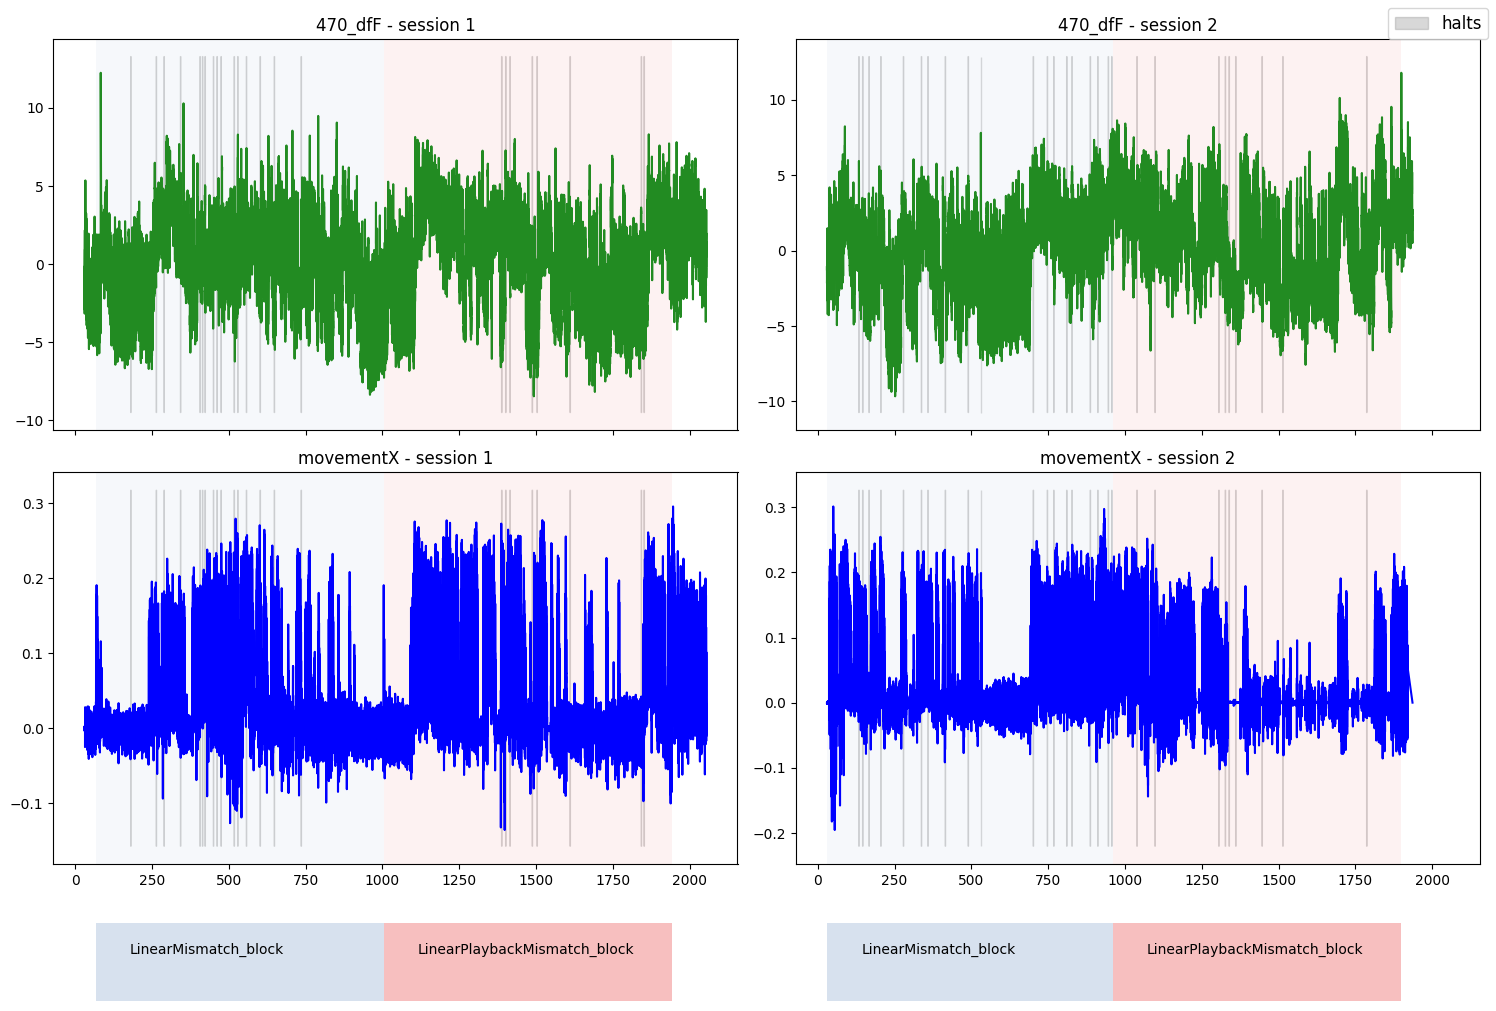

Plotted traces for B3M2


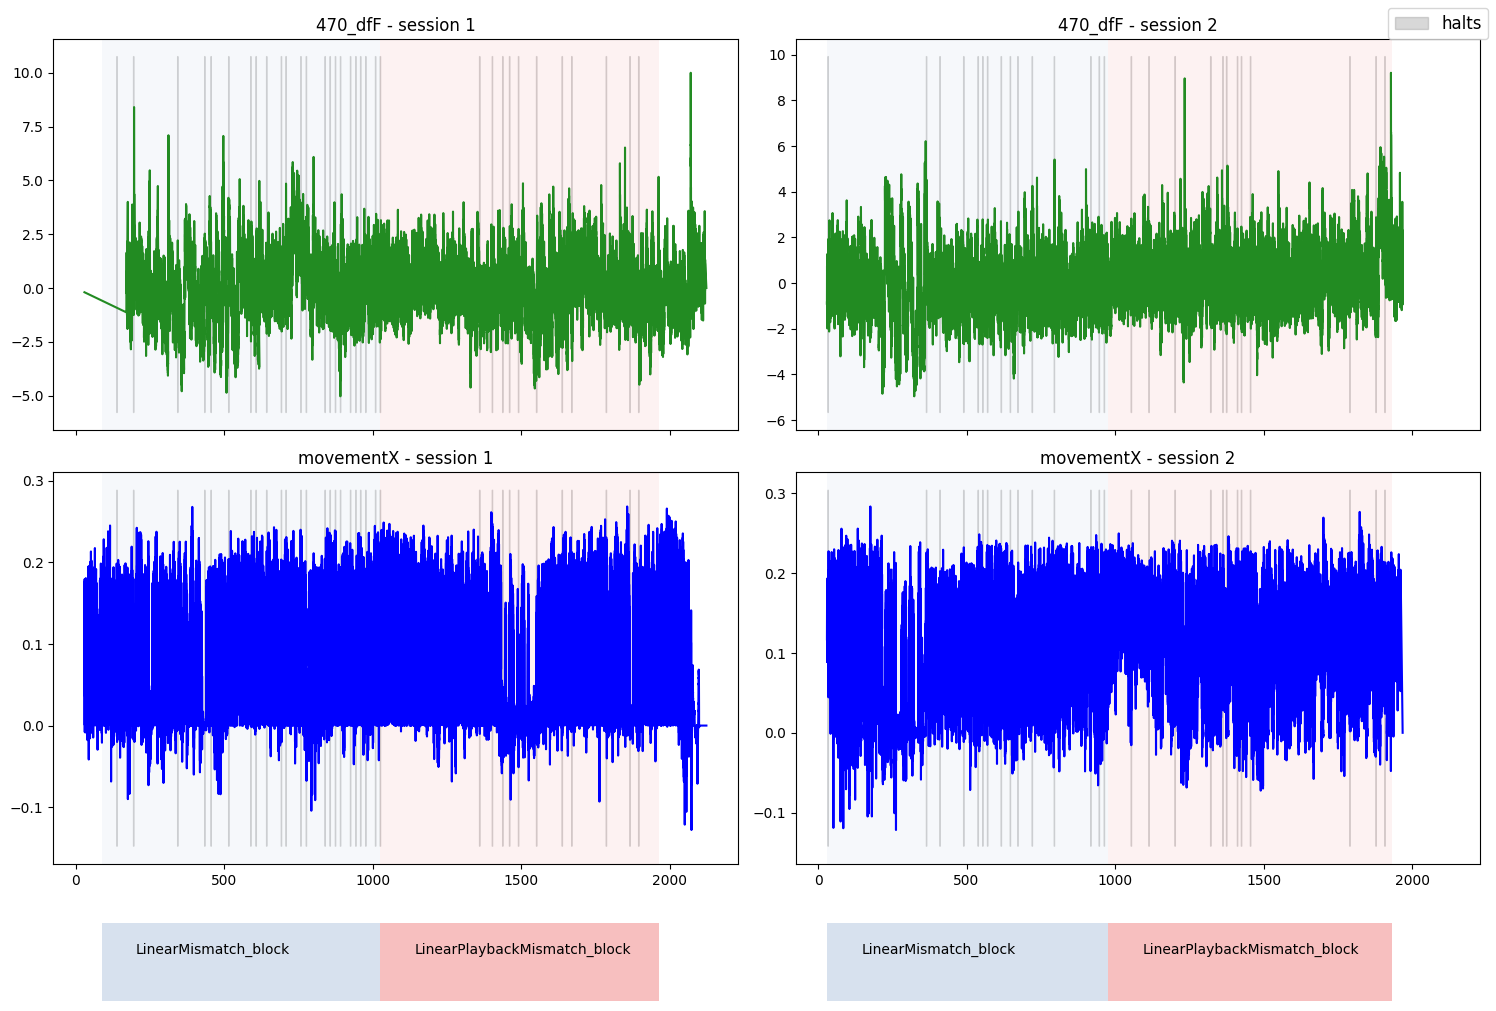

In [7]:
for mouse in G8_MM_1.mouseID.unique():
    mousedata = {'session 1':G8_MM_1.loc[G8_MM_1.mouseID == mouse], 'session 2':G8_MM_2.loc[G8_MM_2.mouseID == mouse]}
    view_session_mouse(mousedata, mouse)

In [8]:
#Filter mice to get unique indexes
mouse_data = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for mouse in G8_MM_1.mouseID.unique():
    mouse_data['session 1']['closedloop'][mouse] = filter_data(G8_MM_1, filters = [mouse, 'closed_block'])
    mouse_data['session 1']['openloop'][mouse] = filter_data(G8_MM_1, filters = [mouse, 'open_block'])
for mouse in G8_MM_2.mouseID.unique():
    mouse_data['session 2']['closedloop'][mouse] = filter_data(G8_MM_2, filters = [mouse, 'closed_block'])
    mouse_data['session 2']['openloop'][mouse] = filter_data(G8_MM_2, filters = [mouse, 'open_block'])

In [119]:
def align_to_event_start(df, trace, event_col, range_around_event):
    
    trace_chunk_list = []
    bsl_trace_chunk_list = []
    run_speed_list = []
    turn_speed_list = []
    event_index_list = []
    
    # Identify the start times for each event
    event_times = df.loc[df[event_col] & ~df[event_col].shift(1, fill_value=False)].index

    # Calculate the time range around each event
    before_0 = range_around_event[0]
    after_0 = range_around_event[1]
    
    # Calculate the target length of each chunk based on the sampling rate
    sampling_rate = 0.001
    target_length = int(((before_0 + after_0) / sampling_rate) + 1)  # Include both ends
    Index= pd.Series(np.linspace(-range_around_event[0], range_around_event[1], target_length)) # common index
    
    for event_time in event_times:
        
        # Determine the time range for each chunk
        start = event_time - before_0
        end = event_time + after_0
        
        # Extract the chunk from the trace column
        chunk = df[trace].loc[start:end]
        runspeed = df['movementX'].loc[start:event_time].mean() #Saving mean run speed up until halt
        turningspeed = df['movementY'].loc[start:event_time].mean() 
        # Normalize the index to start at -before_0
        chunk.index = (chunk.index - chunk.index[0]) - before_0
        # Check if the chunk is shorter than the target length
        if len(chunk) < target_length:
            # Pad the chunk with NaN values at the end to reach the target length
            padding = pd.Series([np.nan] * (target_length - len(chunk)), index=pd.RangeIndex(len(chunk), target_length))
            chunk = pd.concat([chunk, padding])
            chunk.index = Index # Getting the same index as the others
        
        # Baseline the chunk
        baselined_chunk = baseline(chunk)
        
        # Append the chunk and baselined chunk to lists
        trace_chunk_list.append(chunk.values)
        bsl_trace_chunk_list.append(baselined_chunk.values)
        run_speed_list.append(runspeed)
        turn_speed_list.append(turningspeed)
        event_index_list.append(event_time)  # Store the event time for use in final column names
    # Convert lists of arrays to DataFrames
    try:
        trace_chunks = pd.DataFrame(np.column_stack(trace_chunk_list), columns=event_index_list)
        bsl_trace_chunks = pd.DataFrame(np.column_stack(bsl_trace_chunk_list), columns=event_index_list)
        run_speeds = pd.DataFrame(np.column_stack(run_speed_list), columns=event_index_list)
        turn_speeds = pd.DataFrame(np.column_stack(turn_speed_list), columns=event_index_list)
        movement_speeds = pd.concat([run_speeds, turn_speeds])
        
        # Set the index as the common time range index for each chunk
        trace_chunks.index = Index
        bsl_trace_chunks.index = Index
        movement_speeds.index = ['Mean_moveX', 'Mean_moveY'] #set X and Y movement as movement speed index
        
        return trace_chunks, bsl_trace_chunks, movement_speeds
    
    except ValueError:
        if len(event_times) < 1:
            print('could not align to events because there were none, will return nothing')
            
        return 0, 0, 0


In [129]:
#Aligning open and closed loop block data to halt start times
mouse_aligned = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
move_speeds = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged, run_speeds = align_to_event_start(df, '470_dfF', 'halt',[1,2])
            mouse_aligned[session][block][mouse]  = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt
            move_speeds[session][block][mouse]  = run_speeds
    

could not align to events because there were none, will return nothing


In [130]:
print(move_speeds['session 1']['closedloop']['B3M1'])
mouse_aligned['session 1']['closedloop']['B3M1']

             180.608   263.674   288.957   342.440   405.889   414.039  \
Mean_moveX -0.000278  0.073069  0.077854  0.106146  0.103029  0.111999   
Mean_moveY  0.000026  0.010887  0.008196  0.009504  0.013565  0.011434   

             422.422   449.539   461.355   474.455   517.172   528.805  \
Mean_moveX  0.130860  0.076662  0.031469  0.090722  0.090128  0.065463   
Mean_moveY  0.020035  0.011443  0.002663  0.012203  0.010859  0.004414   

             556.904   601.737   647.754   735.203  
Mean_moveX  0.120229  0.088501  0.099724  0.040955  
Mean_moveY  0.018207  0.013311  0.013727  0.007291  


180.608   263.674   288.957   342.440   405.889   414.039   422.422  \
-1.000  0.893200  0.808759 -1.485006  1.370412  0.486514 -1.751622 -1.684634   
-0.999  0.917065  0.796918 -1.467912  1.375058  0.498265 -1.762238 -1.696445   
-0.998  0.940930  0.785077 -1.450818  1.379703  0.510015 -1.774990 -1.708256   
-0.997  0.964795  0.773235 -1.433724  1.384348  0.521765 -1.787743 -1.720067   
-0.996  0.988660  0.761394 -1.416630  1.388994  0.533515 -1.800495 -1.731878   
...          ...       ...       ...       ...       ...       ...       ...   
 1.996 -0.556046  0.085358 -0.864037  0.477381  1.350259  0.145856 -2.079544   
 1.997 -0.550459  0.058852 -0.871840  0.492836  1.344187  0.130554 -2.078087   
 1.998 -0.544872  0.032346 -0.879643  0.508290  1.338114  0.115744 -2.076630   
 1.999 -0.539285  0.005839 -0.887446  0.523745  1.332042  0.102150 -2.075172   
 2.000 -0.533699 -0.020667 -0.895249  0.539199  1.325969  0.088608 -2.073715   

         449.539   461.355   474.455   517.172   528.805   556.904   601.737  \
-1.000  0.251202  1.532164 -0.730746 -1.249215 -0.415138 -0.153782  0.563218   
-0.999  0.248742  1.526851 -0.698289 -1.245754 -0.403388 -0.173456  0.576911   
-0.998  0.246283  1.521537 -0.665832 -1.242292 -0.391638 -0.193131  0.590605   
-0.997  0.243824  1.516224 -0.633760 -1.238831 -0.379888 -0.212806  0.604298   
-0.996  0.241364  1.510910 -0.610572 -1.235370 -0.368137 -0.232481  0.617991   
...          ...       ...       ...       ...       ...       ...       ...   
 1.996  1.239885  1.496127 -3.023576 -2.678555  2.090875 -2.334491  0.477245   
 1.997  1.226100  1.493121 -3.054000 -2.732418  2.108364 -2.337588  0.449615   
 1.998  1.212316  1.490115 -3.084423 -2.786281  2.125853 -2.340685  0.421985   
 1.999  1.198531  1.487109 -3.114846 -2.840144  2.143341 -2.343782  0.394356   
 2.000  1.184747  1.484104 -3.145269 -2.894007  2.160830 -2.346879  0.366726   

         647.754   735.203  
-1.000 -0.337895 -4.848640  
-0.999 -0.342929 -4.828175  
-0.998 -0.326968 -4.807711  
-0.997 -0.306807 -4.787247  
-0.996 -0.286646 -4.766783  
...          ...       ...  
 1.996 -1.537369 -2.941427  
 1.997 -1.542440 -2.960222  
 1.998 -1.547510 -2.979016  
 1.999 -1.557316 -2.997810  
 2.000 -1.578791 -3.016605  

[3001 rows x 16 columns]

In [122]:
len(mouse_aligned['session 1']['closedloop'].keys())

5

In [145]:
mouse_aligned_nohalt = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
move_speeds_nohalt = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged, run_speeds = align_to_event_start(df, '470_dfF', 'No_halt',[1,2])
            mouse_aligned_nohalt[session][block][mouse] = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt
            move_speeds_nohalt[session][block][mouse]  = run_speeds

could not align to events because there were none, will return nothing


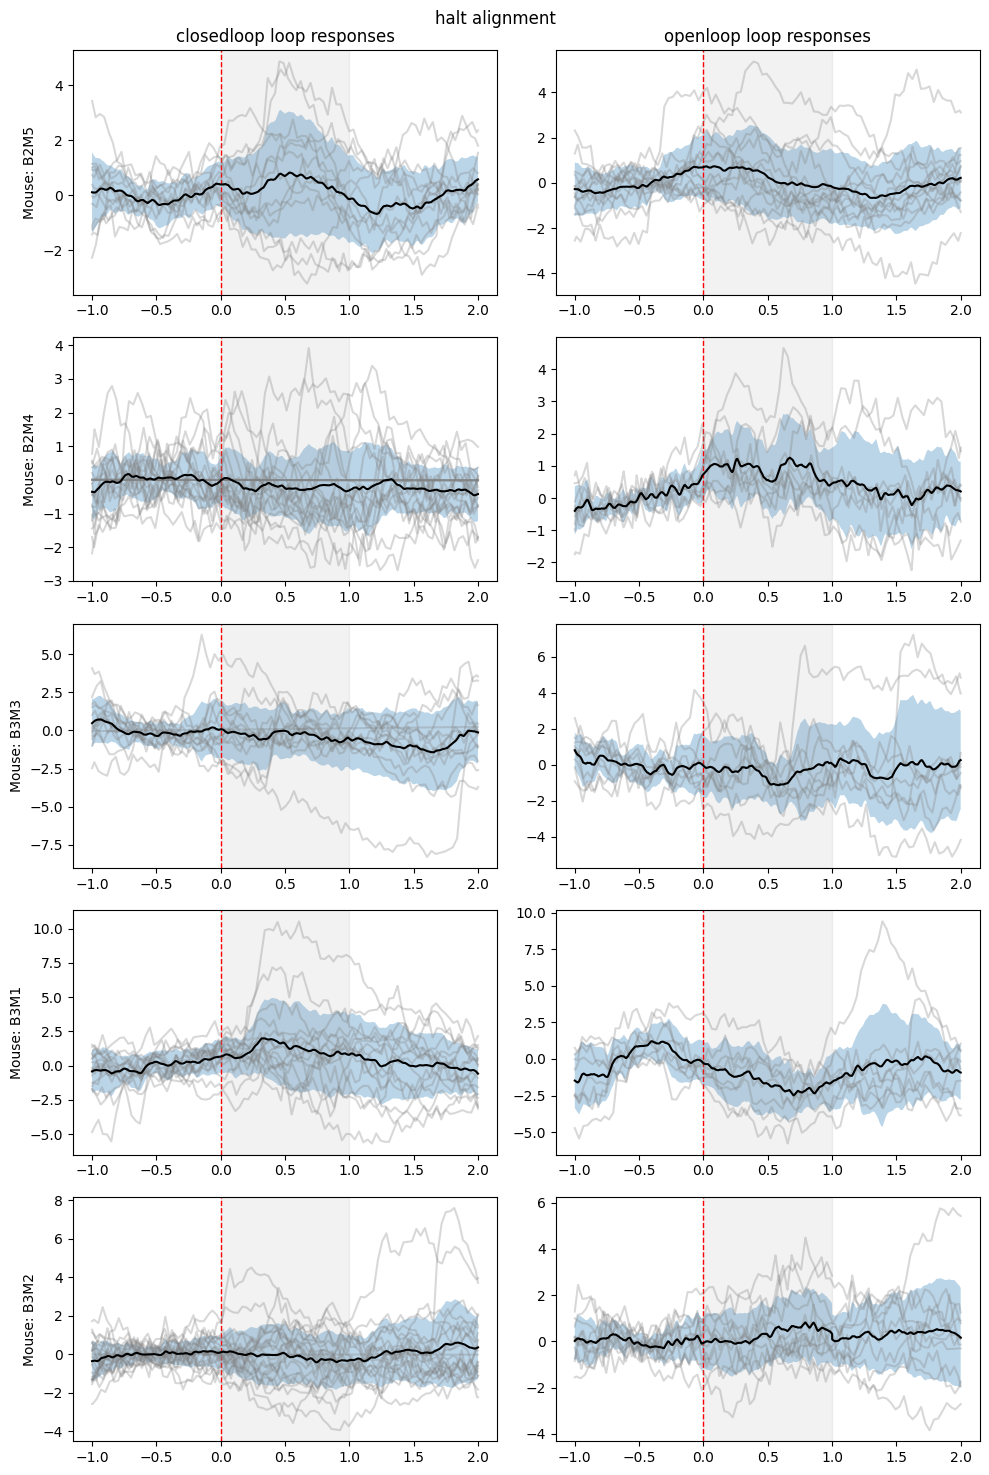

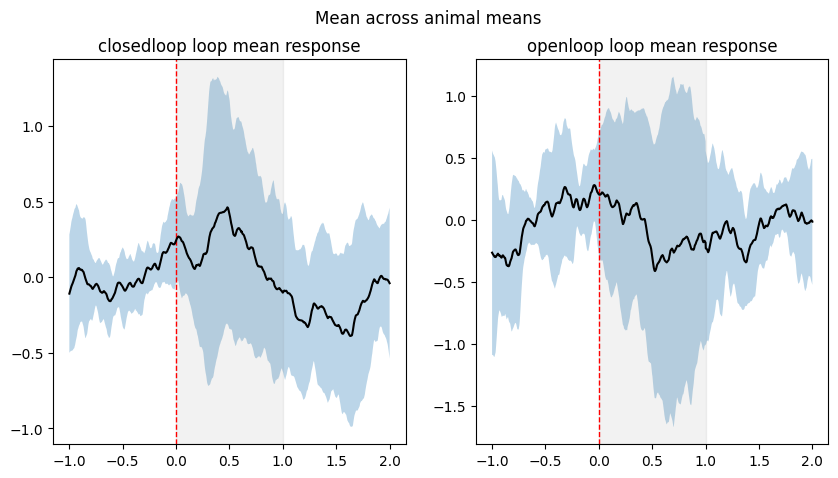

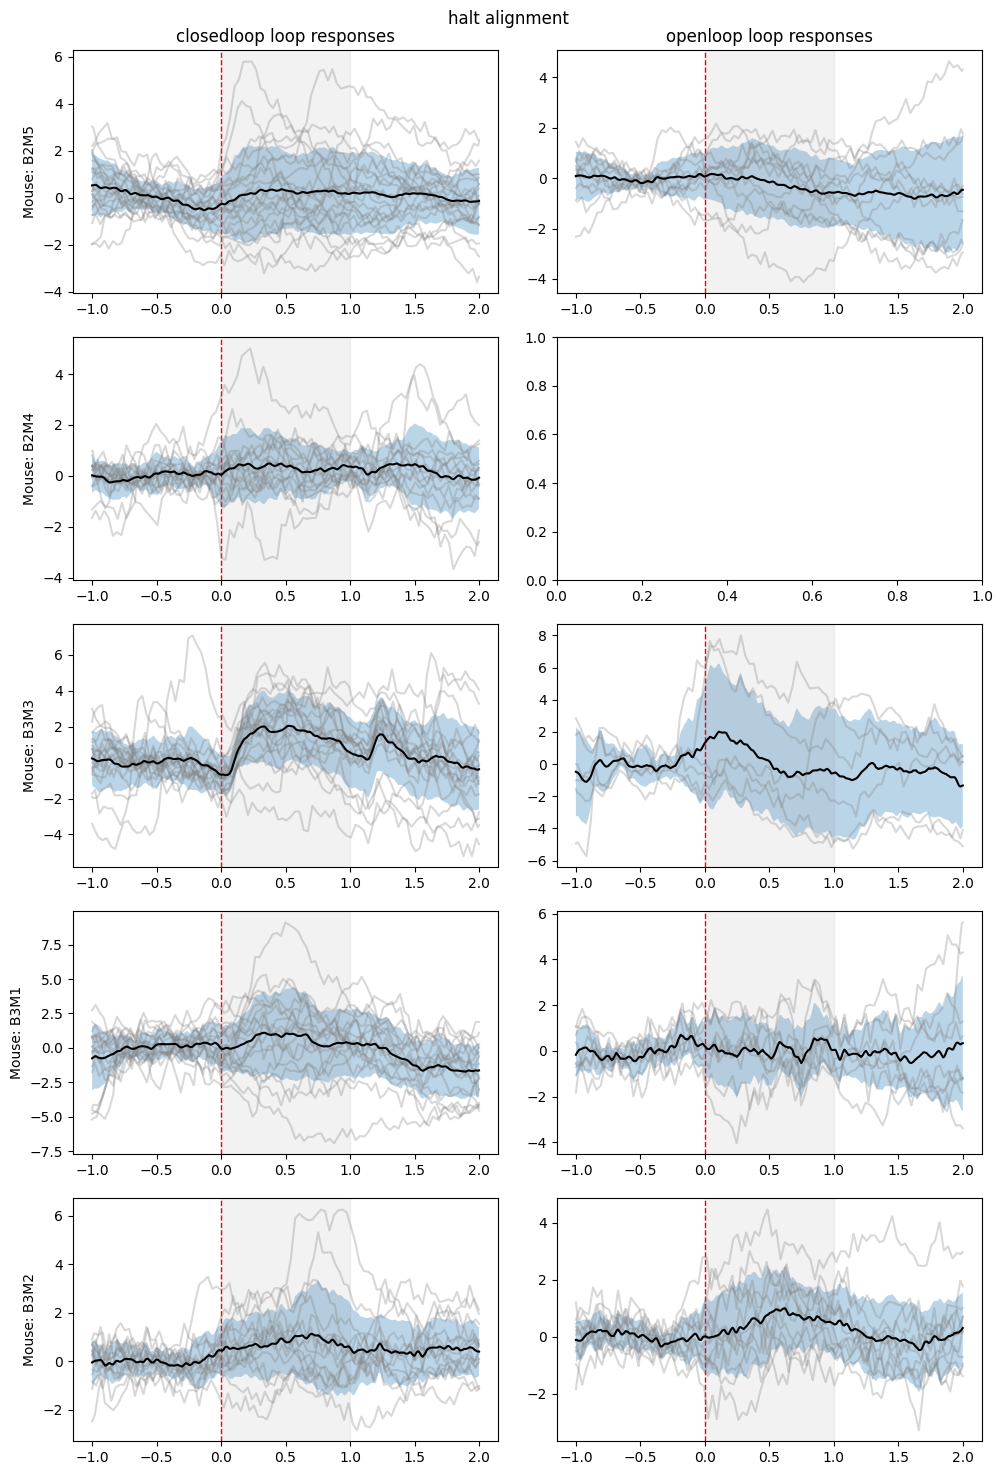

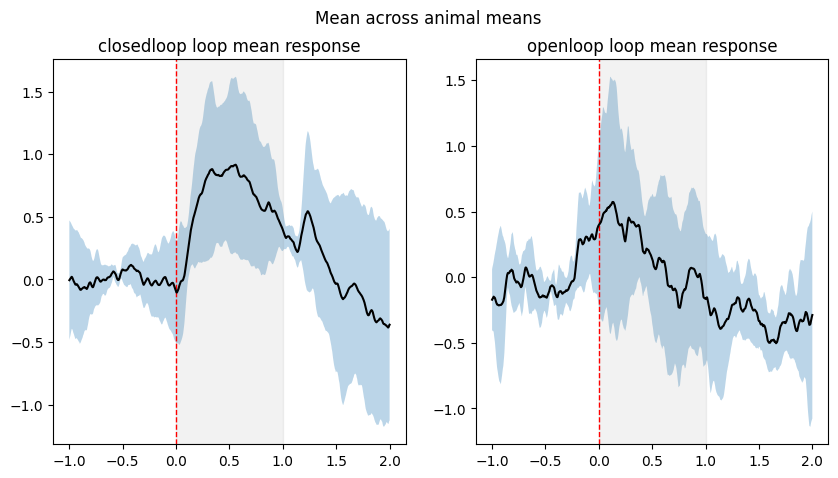

In [146]:
mean_mouse_dict_s1 =plot_compare_blocks(mouse_aligned['session 1'], 'halt')
mean_mouse_dict_s2 =plot_compare_blocks(mouse_aligned['session 2'], 'halt')

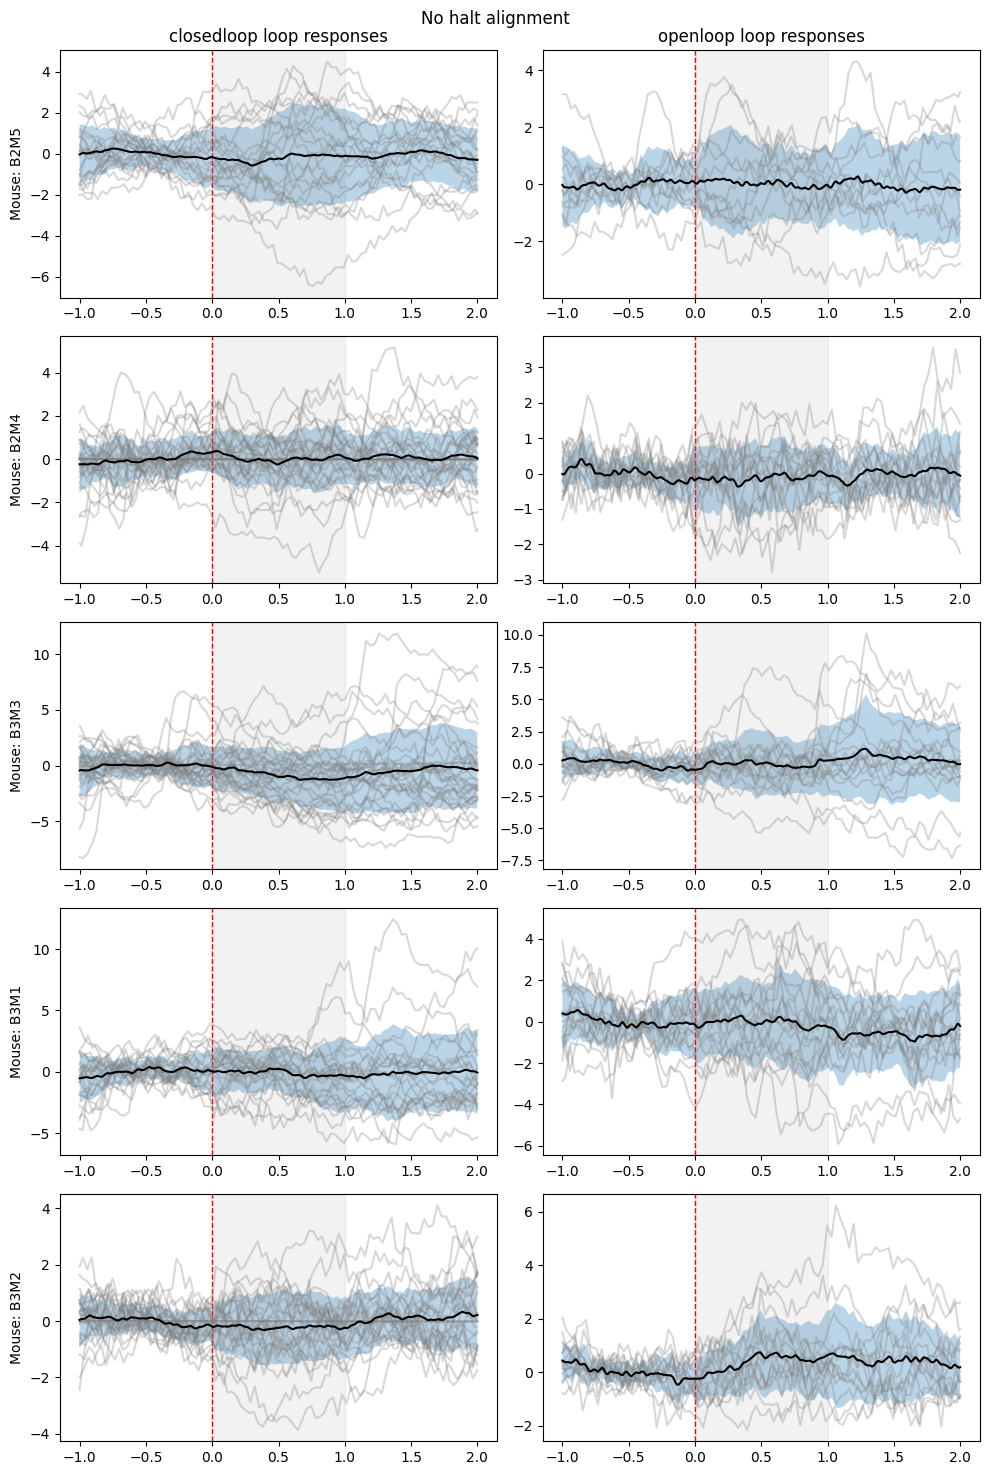

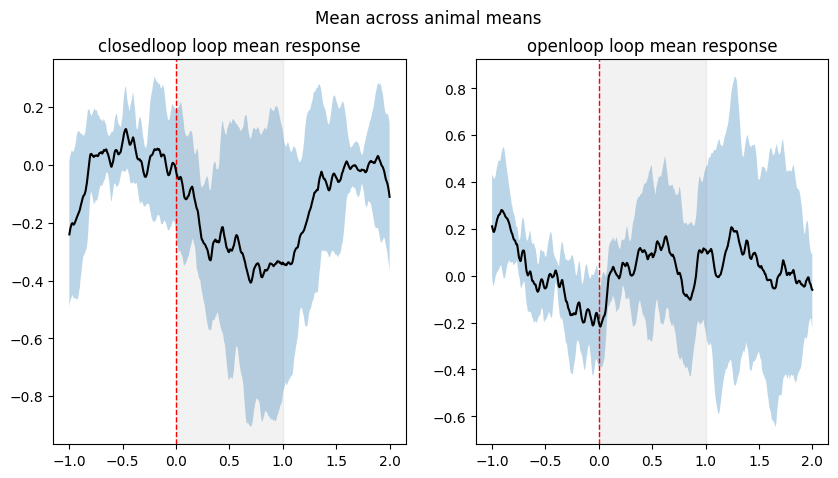

In [147]:
mean_mouse_dict_s1_nohalt =plot_compare_blocks(mouse_aligned_nohalt['session 1'], 'No halt')

In [148]:
sessions = mouse_aligned.keys()

In [149]:
move_speeds['session 1']['openloop']['B2M5']

1100.480  1185.363  1298.578  1309.728  1349.761  1362.278  \
Mean_moveX  0.006828 -0.001607  0.102584  0.119738  0.150027  0.025023   
Mean_moveY  0.000434  0.000286  0.012750  0.007805  0.012892  0.002129   

            1381.844  1411.611  1433.411  1442.811  1453.161  1545.460  \
Mean_moveX  0.114221  0.061645  0.147909  0.000316  0.000336  0.088716   
Mean_moveY  0.009711  0.004767  0.015384  0.000103 -0.000018  0.006187   

            1592.976  1866.241  
Mean_moveX  0.000634  0.139181  
Mean_moveY  0.000076  0.009117

In [139]:
def extract_aligned_data(aligned_data_dict, aligned_movement_dict):
    # Initialize an empty list to store results
    results = []
    
    for session_number, session_blocks in aligned_data_dict.items():
        for session_block, mice_data in session_blocks.items():
            for mouse_id, item in mice_data.items():
                run_df = aligned_movement_dict[session_number][session_block][mouse_id]
                # Check if the item is a DataFrame
                if not isinstance(item, pd.DataFrame):
                    print(f"Warning: The data for Mouse ID '{mouse_id}' in session '{session_number}' and block '{session_block}' is not a DataFrame. Skipping.")
                    continue

                # Copy the DataFrame and ensure the index is numeric
                df = item.copy()
                df.index = pd.to_numeric(df.index)

                # Process each column independently
                for column in df.columns:
                    event_time_data = df.loc[0:1, column]  # Data during the event (0 to +1 seconds)
                    post_event_data = df.loc[1:2, column]  # Data during the first second after the event (+1 to +2 seconds)

                    peak_response = event_time_data.max()  # Max response during the event
                    min_response = event_time_data.min()  # Minimum response during the event
                    mean_response_event = event_time_data.mean()  # Mean response during the event
                    mean_response_post_event = post_event_data.mean()  # Mean response during the post-event time
                    min_response_post_event = post_event_data.min()  #Minimum response during the post-event time
                    peak_response_post_event = post_event_data.max() #Maximum response during the post-event time

                    #Given Mean_moveX and Y being the row names in the movement df, the 1 second pre halt movement speeds are added
                    x_move = run_df.loc['Mean_moveX', column]
                    y_move = run_df.loc['Mean_moveY', column]
    
                    #add results to list of dicts
                    results.append({
                        "SessionNumber": session_number,
                        "SessionBlock": session_block,
                        "MouseID": mouse_id,
                        "EventTime": column,
                        "moveX": x_move,
                        "moveY": y_move,
                        "PeakResponse": peak_response,
                        "MinResponse":  min_response,
                        "MeanResponse": mean_response_event,
                        "MeanResponse_after": mean_response_post_event,
                        "MinResponse_after": min_response_post_event,
                        "PeakResponse_after": peak_response_post_event
                    })

    # convert to a pandas df
    output_df = pd.DataFrame(results)
    return output_df



In [150]:
extracted_variables = extract_aligned_data(mouse_aligned, move_speeds)
extracted_variables

SessionNumber SessionBlock MouseID  EventTime     moveX     moveY  \
0       session 1   closedloop    B2M5    106.104  0.055581  0.004784   
1       session 1   closedloop    B2M5    212.120  0.090729  0.009288   
2       session 1   closedloop    B2M5    313.886  0.103850  0.009088   
3       session 1   closedloop    B2M5    373.535  0.091787  0.011181   
4       session 1   closedloop    B2M5    402.552  0.086683  0.011828   
..            ...          ...     ...        ...       ...       ...   
266     session 2     openloop    B3M2   1425.272  0.117236  0.012613   
267     session 2     openloop    B3M2   1455.689  0.095919  0.011092   
268     session 2     openloop    B3M2   1790.435  0.123360  0.021138   
269     session 2     openloop    B3M2   1878.385  0.063050  0.011725   
270     session 2     openloop    B3M2   1908.318  0.125194  0.019347   

     PeakResponse  MinResponse  MeanResponse  MeanResponse_after  \
0        1.243778    -0.844871      0.062510            0.578885   
1        4.871505    -0.219052      2.294148            0.094350   
2        3.178937    -0.149658      1.947481           -0.192727   
3       -0.346806    -2.786731     -1.914983           -1.252041   
4        2.237293    -1.271451      0.690379           -1.734682   
..            ...          ...           ...                 ...   
266      2.784993    -0.521463      1.237347           -0.994252   
267      0.121090    -2.912162     -1.371198           -1.126389   
268      0.756350    -0.975359      0.073488            0.080203   
269      4.459750     1.180627      2.999079            3.179565   
270      1.081018    -1.377291     -0.051927            0.300799   

     MinResponse_after  PeakResponse_after  
0            -0.015107            1.390267  
1            -1.361233            2.666230  
2            -1.377969            0.992280  
3            -2.703687            1.544427  
4            -2.895559            0.196268  
..                 ...                 ...  
266          -1.838674            0.154675  
267          -3.274219           -0.251507  
268          -0.639360            0.937773  
269           2.479217            4.223612  
270          -0.495426            1.961796  

[271 rows x 12 columns]

In [151]:

results = fit_and_compare_models(
    extracted_variables,
    dependent_variable="PeakResponse",  # Original column name
    independent_vars=["SessionNumber", "SessionBlock", "MouseID"]
)

# Print model summary
print(results["model_summary"])

                            OLS Regression Results                            
Dep. Variable:           PeakResponse   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.630
Date:                Tue, 10 Dec 2024   Prob (F-statistic):             0.0171
Time:                        17:27:42   Log-Likelihood:                -543.91
No. Observations:                 271   AIC:                             1102.
Df Residuals:                     264   BIC:                             1127.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [153]:
extracted_variables_nohalt = extract_aligned_data(mouse_aligned_nohalt, move_speeds_nohalt)

In [154]:
extracted_variables_nohalt['event']='no halt'
extracted_variables['event']='halt'
combined_vars = pd.concat([extracted_variables_nohalt, extracted_variables])

In [155]:

results = fit_and_compare_models(
    combined_vars,
    dependent_variable="PeakResponse",  # Original column name
    independent_vars=["SessionNumber", "SessionBlock", "MouseID", 'event']
)

# Print model summary
print(results["model_summary"])

                            OLS Regression Results                            
Dep. Variable:           PeakResponse   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     5.553
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           3.07e-06
Time:                        17:28:00   Log-Likelihood:                -1397.9
No. Observations:                 709   AIC:                             2812.
Df Residuals:                     701   BIC:                             2848.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [156]:
# Fit a mixed-effects model
mixed_model = smf.mixedlm(
    "PeakResponse ~ event + SessionNumber + SessionBlock",  # Fixed effects
    data=combined_vars,
    groups=combined_vars["MouseID"],  # Random intercept for MouseID
).fit()

print(mixed_model.summary())


                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    PeakResponse
No. Observations:      709        Method:                REML        
No. Groups:            5          Scale:                 3.0551      
Min. group size:       123        Log-Likelihood:        -1408.9420  
Max. group size:       160        Converged:             Yes         
Mean group size:       141.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.784    0.213  8.373 0.000  1.367  2.202
event[T.no halt]           -0.398    0.136 -2.925 0.003 -0.665 -0.131
SessionNumber[T.session 2]  0.130    0.133  0.974 0.330 -0.131  0.390
SessionBlock[T.openloop]   -0.099    0.141 -0.702 0.482 -0.376  0.178
Group Var                   0.137   

In [157]:
# Random slopes for 'event' by 'MouseID'
random_slopes_model = smf.mixedlm(
    "PeakResponse ~ event + SessionNumber + SessionBlock",
    data=combined_vars,
    groups=combined_vars["MouseID"],
    re_formula="~event"  # Random slope for event within MouseID
).fit()

print(random_slopes_model.summary())


                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     PeakResponse
No. Observations:      709         Method:                 REML        
No. Groups:            5           Scale:                  3.0523      
Min. group size:       123         Log-Likelihood:         -1408.9129  
Max. group size:       160         Converged:              Yes         
Mean group size:       141.8                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     1.784    0.212  8.423 0.000  1.369  2.199
event[T.no halt]             -0.395    0.147 -2.689 0.007 -0.683 -0.107
SessionNumber[T.session 2]    0.132    0.133  0.990 0.322 -0.129  0.393
SessionBlock[T.openloop]     -0.101    0.141 -0.713 0.476 -0.378  0.176
Group Var

In [158]:
null_model = smf.mixedlm(
    "PeakResponse ~ SessionNumber + SessionBlock",
    data=combined_vars,
    groups=combined_vars["MouseID"]
).fit()

In [159]:
from scipy.stats import chi2

# Calculate likelihood ratio
ll_null = null_model.llf  # Log-likelihood of the null model
ll_full = mixed_model.llf  # Log-likelihood of the full model
lr_stat = -2 * (ll_null - ll_full)

# Degrees of freedom
df_diff = mixed_model.df_modelwc - null_model.df_modelwc

# p-value
p_value = chi2.sf(lr_stat, df_diff)

print(f"Likelihood Ratio Test Statistic: {lr_stat}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-Value: {p_value}")


Likelihood Ratio Test Statistic: 6.364864143484738
Degrees of Freedom: 1
P-Value: 0.011640200711424891


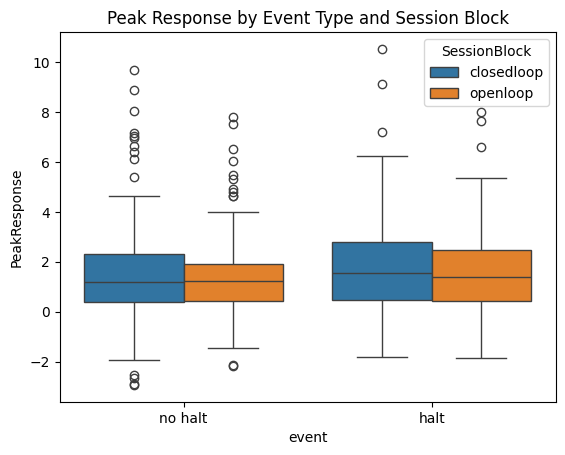

In [160]:

sns.boxplot(x="event", y="PeakResponse", data=combined_vars, hue="SessionBlock")
plt.title("Peak Response by Event Type and Session Block")
plt.show()

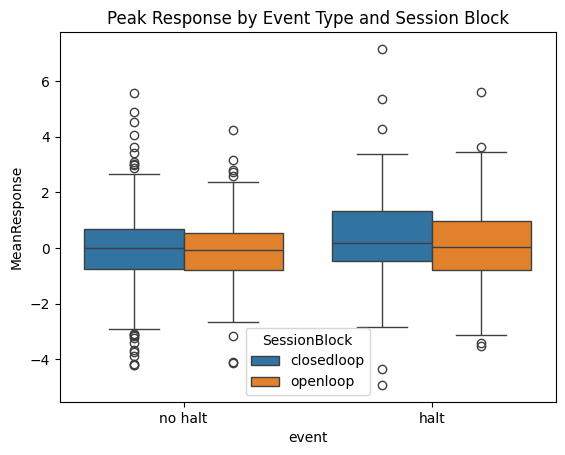

In [161]:
sns.boxplot(x="event", y="MeanResponse", data=combined_vars, hue="SessionBlock")
plt.title("Peak Response by Event Type and Session Block")
plt.show()

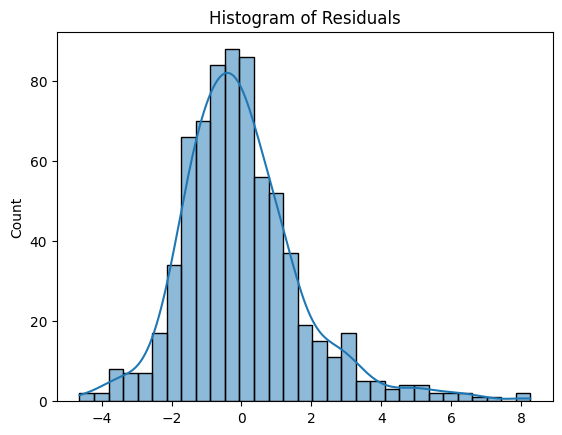

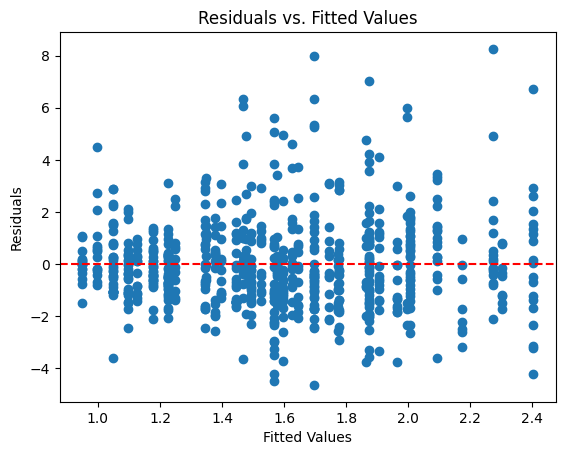

In [162]:
# Extract residuals
residuals = mixed_model.resid

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Residuals vs. fitted values
fitted_values = mixed_model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [163]:
# Function to resample and refit the model
import warnings
from sklearn.exceptions import ConvergenceWarning

def bootstrap_coefficients(model, data, n_bootstraps=1000):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    bootstrap_results = []
    for _ in range(n_bootstraps):
        sample = data.sample(frac=1, replace=True)  # Resample with replacement
        bootstrap_model = smf.mixedlm(
            formula=model.model.formula,
            data=sample,
            groups=sample["MouseID"],
            re_formula="~event"
        ).fit(method='lbfgs', maxiter=100)
        bootstrap_results.append(bootstrap_model.params)
    return pd.DataFrame(bootstrap_results)

# Apply bootstrapping
#bootstrap_results = bootstrap_coefficients(mixed_model, combined_vars)
#print(bootstrap_results.describe())

/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 14.351361
  warnings.warn(msg, ConvergenceWarning)
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning

         Intercept  event[T.no halt]  SessionNumber[T.session 2]  \
count  1000.000000       1000.000000                 1000.000000   
mean      1.784811         -0.388927                    0.140463   
std       0.141865          0.139381                    0.129724   
min       1.398349         -0.814444                   -0.296841   
25%       1.680260         -0.480664                    0.044362   
50%       1.782126         -0.389720                    0.141673   
75%       1.880275         -0.297739                    0.225084   
max       2.303503          0.080924                    0.557106   

       SessionBlock[T.openloop]    Group Var  Group x event[T.no halt] Cov  \
count               1000.000000  1000.000000                   1000.000000   
mean                  -0.106580     0.069074                     -0.018992   
std                    0.144118     0.043986                      0.039324   
min                   -0.540285     0.006343                     -0.267381 

/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 8.580913
  warnings.warn(msg, ConvergenceWarning)


In [172]:
combined_vars.describe()
bootstrap_results.describe()

Intercept  event[T.no halt]  SessionNumber[T.session 2]  \
count  1000.000000       1000.000000                 1000.000000   
mean      1.784811         -0.388927                    0.140463   
std       0.141865          0.139381                    0.129724   
min       1.398349         -0.814444                   -0.296841   
25%       1.680260         -0.480664                    0.044362   
50%       1.782126         -0.389720                    0.141673   
75%       1.880275         -0.297739                    0.225084   
max       2.303503          0.080924                    0.557106   

       SessionBlock[T.openloop]    Group Var  Group x event[T.no halt] Cov  \
count               1000.000000  1000.000000                   1000.000000   
mean                  -0.106580     0.069074                     -0.018992   
std                    0.144118     0.043986                      0.039324   
min                   -0.540285     0.006343                     -0.267381   
25%                   -0.194512     0.035676                     -0.037142   
50%                   -0.111578     0.059390                      0.000197   
75%                   -0.009737     0.089113                      0.007986   
max                    0.421166     0.426715                      0.107852   

       event[T.no halt] Var  
count           1000.000000  
mean               0.050113  
std                0.037956  
min                0.000047  
25%                0.027090  
50%                0.042424  
75%                0.061128  
max                0.303540

Text(0.5, 0.98, 'Non-halts')

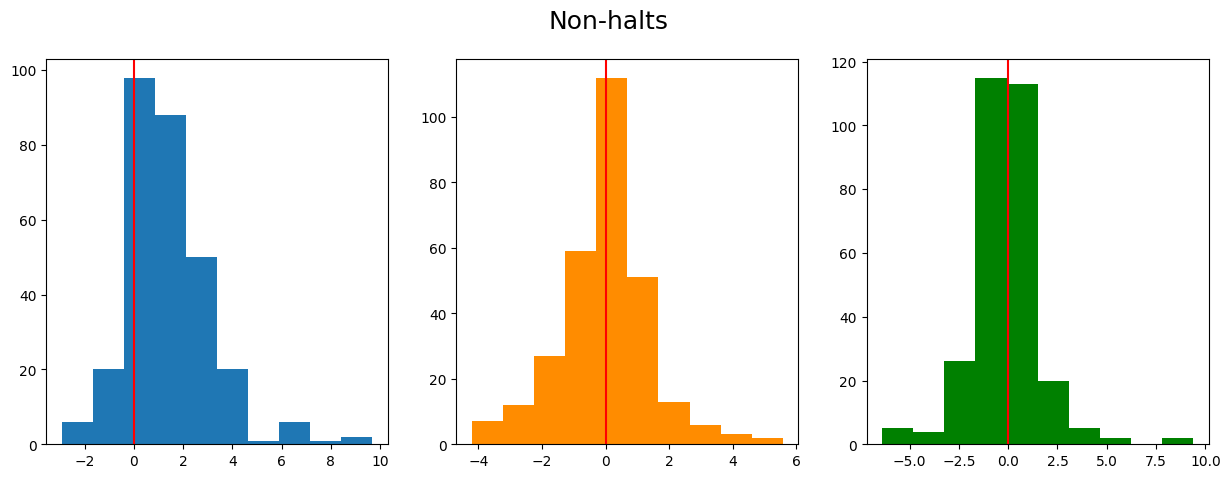

In [173]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(extracted_variables_nohalt.loc[extracted_variables_nohalt['SessionBlock']=='closedloop'].PeakResponse)
ax[0].axvline(0, c='r')
ax[1].hist(extracted_variables_nohalt.loc[extracted_variables_nohalt['SessionBlock']=='closedloop'].MeanResponse, color = 'darkorange')
ax[1].axvline(0, c='r')
ax[2].hist(extracted_variables_nohalt.loc[extracted_variables_nohalt['SessionBlock']=='closedloop'].MeanResponse_after, color = 'g')
ax[2].axvline(0, c='r')
fig.suptitle('Non-halts', fontsize=18)

Text(0.5, 1.0, 'mean response after halt')

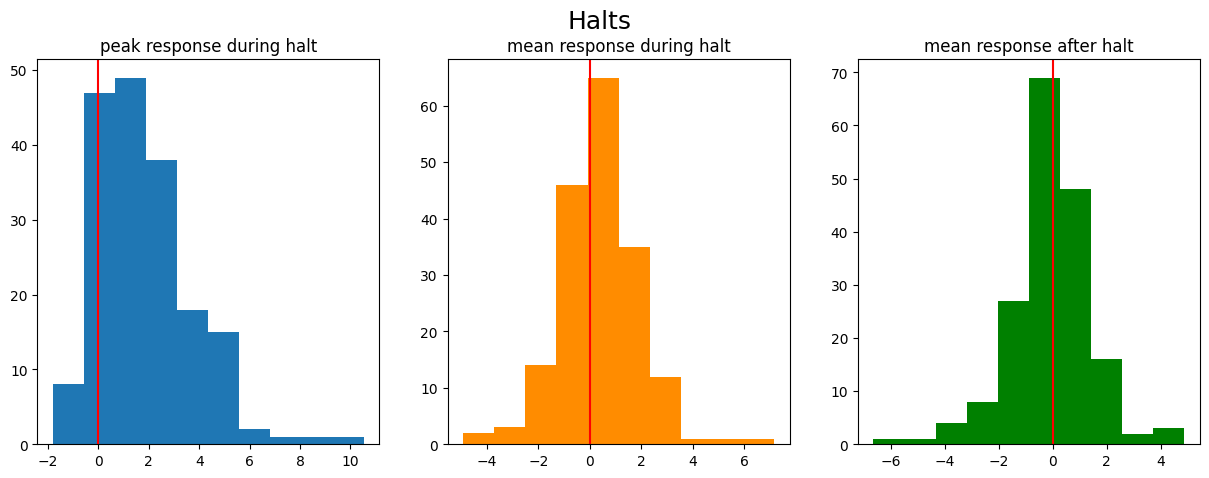

In [174]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(extracted_variables.loc[extracted_variables['SessionBlock']=='closedloop'].PeakResponse)
ax[0].axvline(0, c='r')
ax[0].set_title('peak response during halt')
ax[1].hist(extracted_variables.loc[extracted_variables['SessionBlock']=='closedloop'].MeanResponse, color = 'darkorange')
ax[1].axvline(0, c='r')
ax[1].set_title('mean response during halt')
ax[2].hist(extracted_variables.loc[extracted_variables['SessionBlock']=='closedloop'].MeanResponse_after, color = 'g')
ax[2].axvline(0, c='r')
fig.suptitle('Halts', fontsize=18)
ax[2].set_title('mean response after halt')

Text(0.5, 1.0, 'mean response after halt')

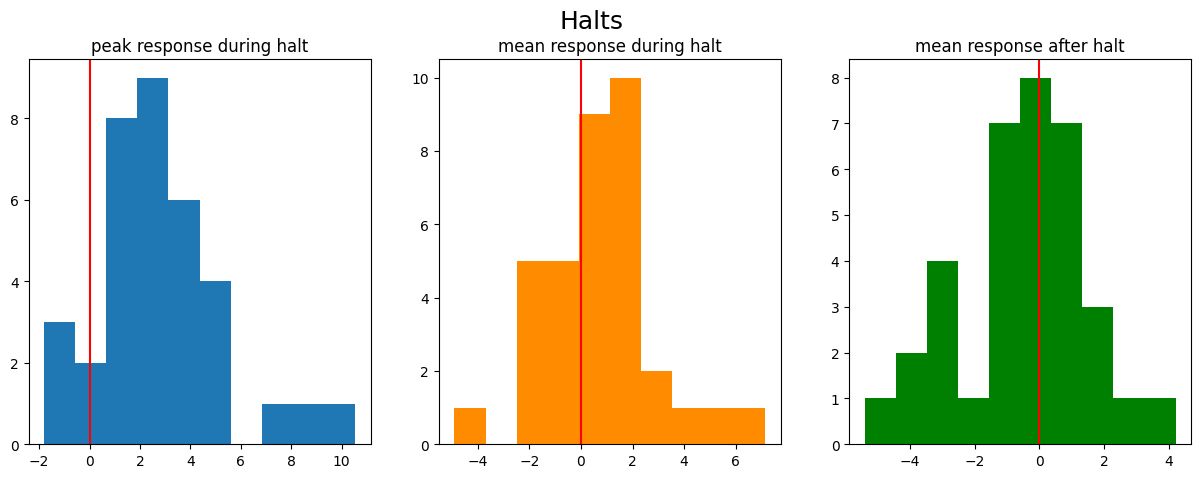

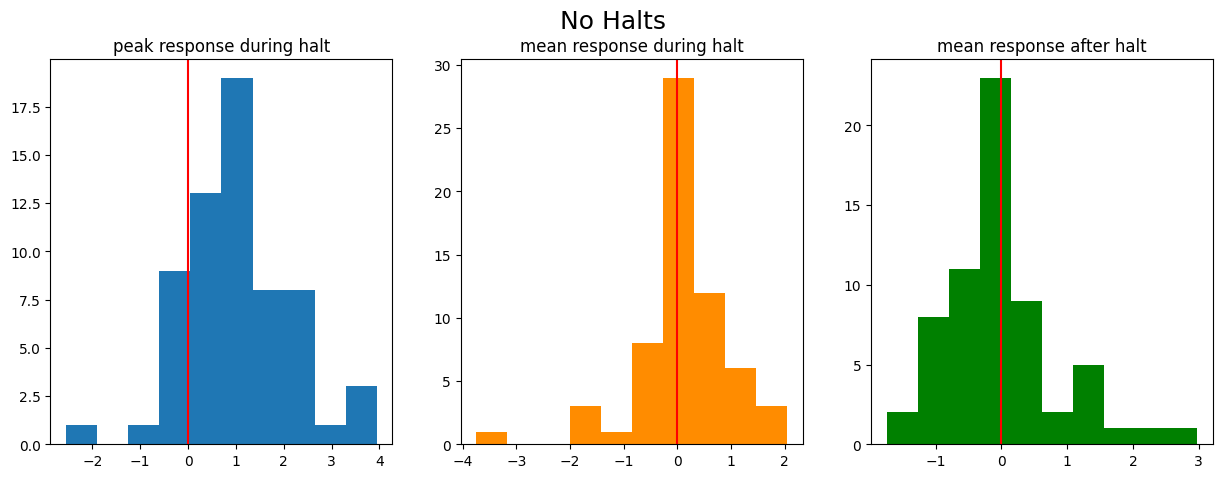

In [175]:
mouse = 'B3M1'

SpecificMouse_aligned = extracted_variables.loc[extracted_variables['MouseID']==mouse]
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(SpecificMouse_aligned.loc[SpecificMouse_aligned['SessionBlock']=='closedloop'].PeakResponse)
ax[0].axvline(0, c='r')
ax[0].set_title('peak response during halt')
ax[1].hist(SpecificMouse_aligned.loc[SpecificMouse_aligned['SessionBlock']=='closedloop'].MeanResponse, color = 'darkorange')
ax[1].axvline(0, c='r')
ax[1].set_title('mean response during halt')
ax[2].hist(SpecificMouse_aligned.loc[SpecificMouse_aligned['SessionBlock']=='closedloop'].MeanResponse_after, color = 'g')
ax[2].axvline(0, c='r')
fig.suptitle('Halts', fontsize=18)
ax[2].set_title('mean response after halt')

SpecificMouse_aligned_nohalt = extracted_variables_nohalt.loc[extracted_variables_nohalt['MouseID']=='B2M4']
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(SpecificMouse_aligned_nohalt.loc[SpecificMouse_aligned_nohalt['SessionBlock']=='closedloop'].PeakResponse)
ax[0].axvline(0, c='r')
ax[0].set_title('peak response during halt')
ax[1].hist(SpecificMouse_aligned_nohalt.loc[SpecificMouse_aligned_nohalt['SessionBlock']=='closedloop'].MeanResponse, color = 'darkorange')
ax[1].axvline(0, c='r')
ax[1].set_title('mean response during halt')
ax[2].hist(SpecificMouse_aligned_nohalt.loc[SpecificMouse_aligned_nohalt['SessionBlock']=='closedloop'].MeanResponse_after, color = 'g')
ax[2].axvline(0, c='r')
fig.suptitle('No Halts', fontsize=18)
ax[2].set_title('mean response after halt')

In [176]:
extracted_variables

SessionNumber SessionBlock MouseID  EventTime     moveX     moveY  \
0       session 1   closedloop    B2M5    106.104  0.055581  0.004784   
1       session 1   closedloop    B2M5    212.120  0.090729  0.009288   
2       session 1   closedloop    B2M5    313.886  0.103850  0.009088   
3       session 1   closedloop    B2M5    373.535  0.091787  0.011181   
4       session 1   closedloop    B2M5    402.552  0.086683  0.011828   
..            ...          ...     ...        ...       ...       ...   
266     session 2     openloop    B3M2   1425.272  0.117236  0.012613   
267     session 2     openloop    B3M2   1455.689  0.095919  0.011092   
268     session 2     openloop    B3M2   1790.435  0.123360  0.021138   
269     session 2     openloop    B3M2   1878.385  0.063050  0.011725   
270     session 2     openloop    B3M2   1908.318  0.125194  0.019347   

     PeakResponse  MinResponse  MeanResponse  MeanResponse_after  \
0        1.243778    -0.844871      0.062510            0.578885   
1        4.871505    -0.219052      2.294148            0.094350   
2        3.178937    -0.149658      1.947481           -0.192727   
3       -0.346806    -2.786731     -1.914983           -1.252041   
4        2.237293    -1.271451      0.690379           -1.734682   
..            ...          ...           ...                 ...   
266      2.784993    -0.521463      1.237347           -0.994252   
267      0.121090    -2.912162     -1.371198           -1.126389   
268      0.756350    -0.975359      0.073488            0.080203   
269      4.459750     1.180627      2.999079            3.179565   
270      1.081018    -1.377291     -0.051927            0.300799   

     MinResponse_after  PeakResponse_after event  
0            -0.015107            1.390267  halt  
1            -1.361233            2.666230  halt  
2            -1.377969            0.992280  halt  
3            -2.703687            1.544427  halt  
4            -2.895559            0.196268  halt  
..                 ...                 ...   ...  
266          -1.838674            0.154675  halt  
267          -3.274219           -0.251507  halt  
268          -0.639360            0.937773  halt  
269           2.479217            4.223612  halt  
270          -0.495426            1.961796  halt  

[271 rows x 13 columns]

In [177]:
interaction_model = smf.mixedlm(
    "PeakResponse ~ event * SessionBlock + SessionNumber",
    data=combined_vars,
    groups=combined_vars["MouseID"],
    re_formula="~event"
).fit()

print(interaction_model.summary())

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         PeakResponse
No. Observations:           709             Method:                     REML        
No. Groups:                 5               Scale:                      3.0559      
Min. group size:            123             Log-Likelihood:             -1409.1167  
Max. group size:            160             Converged:                  Yes         
Mean group size:            141.8                                                   
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  1.814    0.220  8.233 0.000  1.382  2.246
event[T.no halt]                          -0.444    0.175 -2.531 0.011 -0.787 -0.100
Sess

In [187]:
response_running = smf.ols('PeakResponse ~ moveX', data=combined_vars).fit()

print(response_running.summary())
#print(response_running.t_test('PeakResponse'))
print("MSE=%.3f" % response_running.mse_resid)


                            OLS Regression Results                            
Dep. Variable:           PeakResponse   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.029
Date:                Tue, 10 Dec 2024   Prob (F-statistic):              0.155
Time:                        17:38:43   Log-Likelihood:                -1416.0
No. Observations:                 709   AIC:                             2836.
Df Residuals:                     707   BIC:                             2845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7222      0.124     13.907      0.0

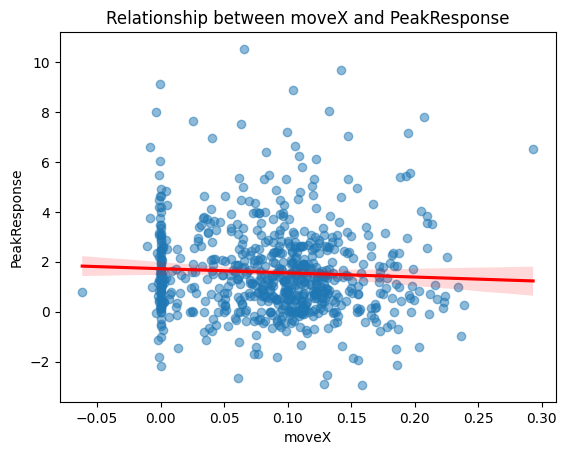

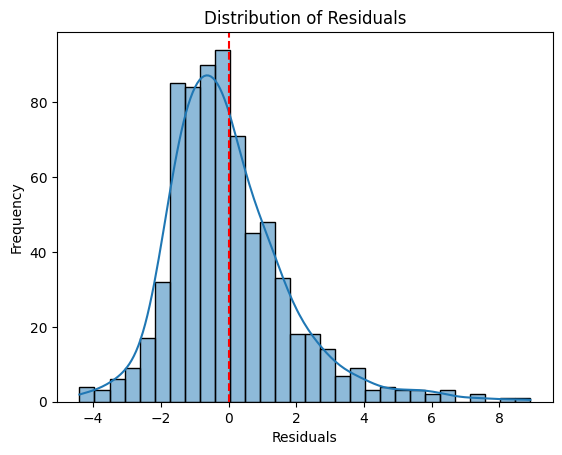

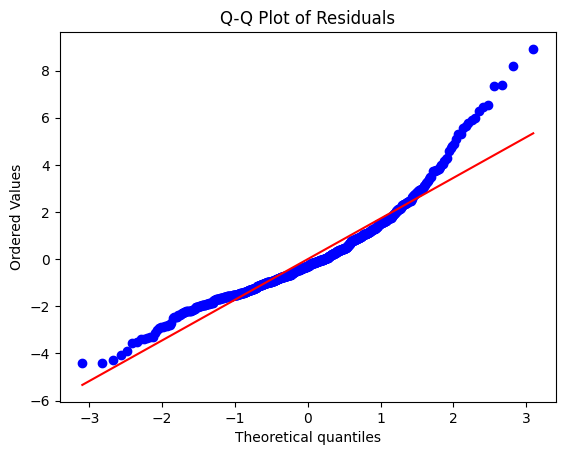

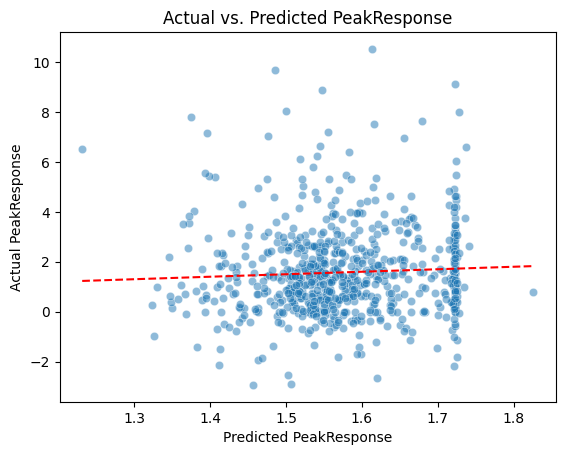

/var/folders/j0/v9b_1b8d44l7jr8z9bvwrg4h0000gp/T/ipykernel_51069/1019018932.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Coefficient", y="Variable", data=coef_df, ci=None)


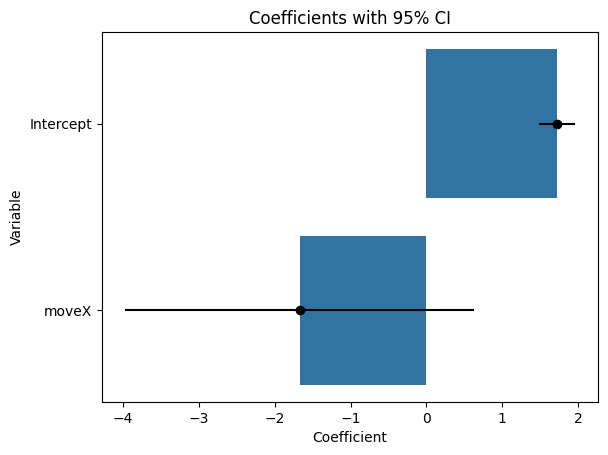

In [194]:
# Scatterplot with regression line
sns.regplot(
    x="moveX",
    y="PeakResponse",
    data=combined_vars,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.5}
)
plt.title("Relationship between moveX and PeakResponse")
plt.xlabel("moveX")
plt.ylabel("PeakResponse")
plt.show()

sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Q-Q plot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

predicted = 1.7222 + (-1.6735 * combined_vars["moveX"])

# Actual vs. predicted plot
sns.scatterplot(x=predicted, y=combined_vars["PeakResponse"], alpha=0.5)
plt.plot([min(predicted), max(predicted)], [min(predicted), max(predicted)], color="red", linestyle="--")
plt.title("Actual vs. Predicted PeakResponse")
plt.xlabel("Predicted PeakResponse")
plt.ylabel("Actual PeakResponse")
plt.show()


# Example coefficients and CI
coef_df = pd.DataFrame({
    "Variable": ["Intercept", "moveX"],
    "Coefficient": [1.7222, -1.6735],
    "CI Lower": [1.479, -3.980],
    "CI Upper": [1.965, 0.633]
})

# Coefficient bar plot
sns.barplot(x="Coefficient", y="Variable", data=coef_df, ci=None)
plt.errorbar(
    coef_df["Coefficient"], coef_df["Variable"], 
    xerr=[coef_df["Coefficient"] - coef_df["CI Lower"], coef_df["CI Upper"] - coef_df["Coefficient"]],
    fmt="o", color="black"
)
plt.title("Coefficients with 95% CI")
plt.show()


In [179]:
##Consider adding to the fitted model a continous variable which is the time column
#EventTime should currently be seconds from session start